# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='Reacher.many.app')

# select this option to load version 2 (with 20 agents) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
print(scores)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total score (averaged over agents) this episode: 0.06149999862536788


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import namedtuple, deque
import random
import copy

In [2]:
import sys
sys.path.insert(0, './classes')
from models import Actor, Critic
from agents import Agent

In [3]:
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
import time
import numpy as np
from collections import deque
import torch

In [6]:
def ddpg(n_episodes=500, max_t=1000, solved_score=30.0, consec_episodes=100, print_every=1, train_mode=True,
         actor_path='./models/actor_ckpt.pth', critic_path='./models/critic_ckpt.pth', num_agents = 20):
    
    mean_scores = []                               # list of mean scores from each episode
    min_scores = []                                # list of lowest scores from each episode
    max_scores = []                                # list of highest scores from each episode
    best_score = -np.inf
    scores_window = deque(maxlen=consec_episodes)  # mean scores from most recent episodes
    moving_avgs = []                               # list of moving averages
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        scores = np.zeros(num_agents)                           # initialize score for each agent
        agent.reset()
        start_time = time.time()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)         # select an action
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode has finished
            # save experience to replay buffer, perform learning step at defined interval
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)             
            states = next_states
            scores += rewards        
            if np.any(dones):                                   # exit loop when episode ends
                break

        duration = time.time() - start_time
        min_scores.append(np.min(scores))             # save lowest score for a single agent
        max_scores.append(np.max(scores))             # save highest score for a single agent        
        mean_scores.append(np.mean(scores))           # save mean score for the episode
        scores_window.append(mean_scores[-1])         # save mean score to window
        moving_avgs.append(np.mean(scores_window))    # save moving average
                
        if i_episode % print_every == 0:
            print('\rEpisode {} \tMin: {:.1f}\tMax: {:.1f}\tMean: {:.1f}\tMov. Avg: {:.1f}'.format(\
                  i_episode, min_scores[-1], max_scores[-1], mean_scores[-1], moving_avgs[-1]))
                          
        if moving_avgs[-1] >= solved_score and i_episode >= consec_episodes:
            print('\nEnvironment SOLVED in {} episodes!\tMoving Average ={:.1f} over last {} episodes'.format(\
                                    i_episode, moving_avgs[-1], consec_episodes))            
            if train_mode:
                torch.save(agent.actor_local.state_dict(), actor_path)
                torch.save(agent.critic_local.state_dict(), critic_path)  
            break
            
    return mean_scores, moving_avgs

In [7]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)
scores, avgs = ddpg()

Episode 1 	Min: 0.5	Max: 2.0	Mean: 1.1	Mov. Avg: 1.1
Episode 2 	Min: 0.5	Max: 4.3	Mean: 2.6	Mov. Avg: 1.8
Episode 3 	Min: 1.2	Max: 6.1	Mean: 3.8	Mov. Avg: 2.5
Episode 4 	Min: 1.4	Max: 5.8	Mean: 3.5	Mov. Avg: 2.7
Episode 5 	Min: 1.7	Max: 6.9	Mean: 4.2	Mov. Avg: 3.0
Episode 6 	Min: 3.1	Max: 6.8	Mean: 5.1	Mov. Avg: 3.4
Episode 7 	Min: 4.5	Max: 8.8	Mean: 6.3	Mov. Avg: 3.8
Episode 8 	Min: 3.4	Max: 17.5	Mean: 8.4	Mov. Avg: 4.4
Episode 9 	Min: 4.6	Max: 12.6	Mean: 7.9	Mov. Avg: 4.7
Episode 10 	Min: 4.5	Max: 17.9	Mean: 10.1	Mov. Avg: 5.3
Episode 11 	Min: 6.4	Max: 17.7	Mean: 11.7	Mov. Avg: 5.9
Episode 12 	Min: 7.4	Max: 14.8	Mean: 11.7	Mov. Avg: 6.4
Episode 13 	Min: 4.6	Max: 16.0	Mean: 11.1	Mov. Avg: 6.7
Episode 14 	Min: 6.6	Max: 17.6	Mean: 11.7	Mov. Avg: 7.1
Episode 15 	Min: 7.6	Max: 17.0	Mean: 12.5	Mov. Avg: 7.4
Episode 16 	Min: 8.9	Max: 20.2	Mean: 14.3	Mov. Avg: 7.9
Episode 17 	Min: 11.0	Max: 21.4	Mean: 16.9	Mov. Avg: 8.4
Episode 18 	Min: 9.9	Max: 20.0	Mean: 14.9	Mov. Avg: 8.8
Episode 19 	Min:

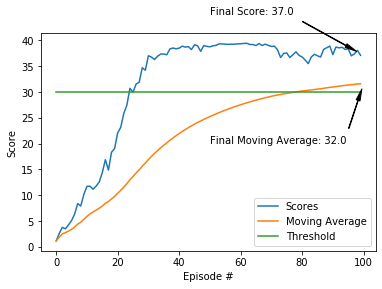

In [32]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label = 'Scores')
plt.plot(np.arange(len(scores)), avgs, label = 'Moving Average')
plt.plot(np.arange(len(scores)), np.full(len(scores), 30), label = 'Threshold')
arrow_properties = dict(
    facecolor="black", width=0.5,
    headwidth=4, shrink=0.1)

plt.annotate(
    "Final Score: " + str(round(scores[-1])), xy=(100, scores[-1]),
    xytext=(50, 45),
    arrowprops=arrow_properties)

plt.annotate(
    "Final Moving Average: " + str(round(avgs[-1])), xy=(100, avgs[-1]),
    xytext=(50, 20),
    arrowprops=arrow_properties)

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [5]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)

In [6]:
# Load the saved weights
agent.actor_local.load_state_dict(torch.load('./models/actor_ckpt.pth', map_location='cpu'))
agent.critic_local.load_state_dict(torch.load('./models/critic_ckpt.pth', map_location='cpu'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(20)                          # initialize the score (for each agent)

# Run for a time
for _ in range(1000):
    actions = agent.act(states, add_noise = False)                        # select actions from loaded model agent
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break

print('Total score: {}'.format(np.mean(scores)))

Total score: 38.50549913933501


In [10]:
env.close()